In [1]:
import numpy as np
import os
import json
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Input, Dropout,GlobalAveragePooling2D, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix , classification_report
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

# 3=cat, 5=dog
train_mask = (y_train == 3) | (y_train == 5)
test_mask = (y_test == 3) | (y_test == 5)

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

#cat=0, dog=1
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)


x_train_32 = x_train.astype('float32') / 255
x_test_32 = x_test.astype('float32') / 255

In [4]:
print(f"Training data shape: {x_train_32.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test_32.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (10000, 32, 32, 3)
Training labels shape: (10000,)
Test data shape: (2000, 32, 32, 3)
Test labels shape: (2000,)


In [ ]:
def create_balanced_val_test_splits(x_test, y_test, val_ratio=0.5):

    cat_indices = np.where(y_test == 0)[0]
    dog_indices = np.where(y_test == 1)[0]


    n_val_cats = int(len(cat_indices) * val_ratio)
    n_val_dogs = int(len(dog_indices) * val_ratio)

    np.random.shuffle(cat_indices)
    np.random.shuffle(dog_indices)

    val_cat_indices = cat_indices[:n_val_cats]
    val_dog_indices = dog_indices[:n_val_dogs]

    test_cat_indices = cat_indices[n_val_cats:]
    test_dog_indices = dog_indices[n_val_dogs:]

    
    val_indices = np.concatenate([val_cat_indices, val_dog_indices])
    test_indices = np.concatenate([test_cat_indices, test_dog_indices])

    
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)

    
    x_val, y_val = x_test[val_indices], y_test[val_indices]
    x_test_final, y_test_final = x_test[test_indices], y_test[test_indices]

    # Verify balance
    # print(f"Validation set: {len(y_val)} samples")
    # print(f"  Cats: {np.sum(y_val == 0)}, Dogs: {np.sum(y_val == 1)}")
    # print(f"Test set: {len(y_test_final)} samples")
    # print(f"  Cats: {np.sum(y_test_final == 0)}, Dogs: {np.sum(y_test_final == 1)}")

    return x_val, y_val, x_test_final, y_test_final


In [3]:
def visualize_data(x, y,count: tuple, figsize: tuple):

  plt.figure(figsize=figsize)
  sizee = count[0] * count[1]
  for i in range (sizee):
    plt.subplot(count[0], count[1],i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.axis('off')

  plt.show()

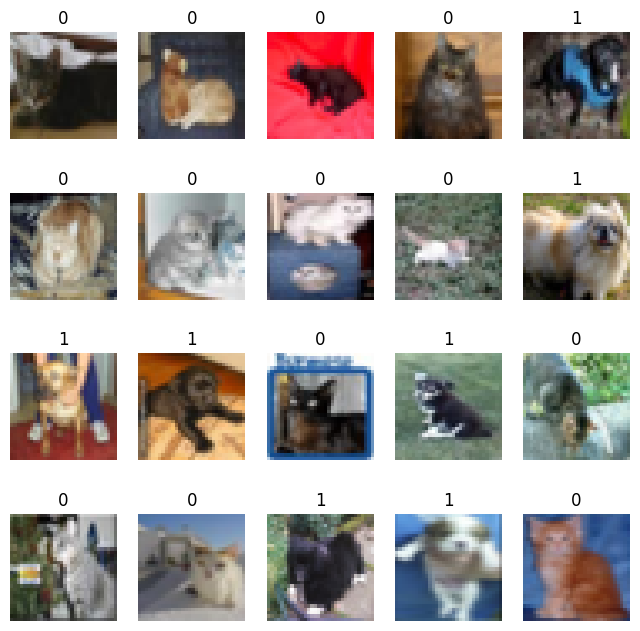

In [4]:
visualize_data(x_train_32, y_train, (4, 5), (8, 8))

optimized pipeline

In [ ]:
def create_dataset(x_data, y_data,target_size=(32,32), batch_size=32, training=False, seed=42):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))

    if(target_size != (32,32)):
        dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, target_size), y),
        num_parallel_calls=tf.data.AUTOTUNE
        )

        
        dataset = dataset.map(
            lambda x, y: (x / 255.0, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    if training:
        
        dataset = dataset.map(
            lambda x, y: (tf.image.random_flip_left_right(x, seed=seed), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.shuffle(1000, seed=seed, reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
batch_size = 32
seed = 42 

x_val_32, y_val, x_test_final_32, y_test_final = create_balanced_val_test_splits(x_test_32, y_test, val_ratio= 0.5)



# For 32x32 images
train_dataset_32 = create_dataset(x_train_32, y_train,target_size=(32,32), batch_size = batch_size, training=True, seed= seed)
val_dataset_32 = create_dataset(x_val_32, y_val,target_size=(32,32), batch_size = batch_size, training=False, seed= seed)
test_dataset_32 = create_dataset(x_test_final_32, y_test_final,target_size=(32,32), batch_size = batch_size, training=False, seed= seed)

# For 64x64 images
train_dataset_64 = create_dataset(x_train_32, y_train,target_size=(64,64), batch_size = batch_size, training=True, seed= seed)
val_dataset_64 = create_dataset(x_val_32, y_val,target_size=(64,64), batch_size = batch_size, training=False, seed= seed)
test_dataset_64 = create_dataset(x_test_final_32, y_test_final,target_size=(64,64), batch_size = batch_size, training=False, seed= seed)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [ ]:
def train_and_evaluate_model(model, train_dataset, test_dataset , validation_dataset,
                             epochs=30,model_name="Model", callbacks=None):

   
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=1,
        shuffle = False
    )

    # Plot loss
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel("Binary Crossentropy Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print(f"{model_name} Test Accuracy: {test_acc*100:.2f}%")

    return history, (test_loss, test_acc)

In [10]:
def report(model,model_name,model_history,test_dataset):
  best_val_acc = max(model_history.history["val_accuracy"])
  best_val_loss = min(model_history.history["val_loss"])
  best_train_acc = max(model_history.history["accuracy"])
  best_train_loss = min(model_history.history["loss"])

  y_true, y_pred = [], []          
  for x, y in test_dataset:
      y_true.append(y.numpy().flatten())
      y_pred.append((model.predict(x, verbose=0) > 0.5).astype("int32").flatten())

  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)
  
  cm = confusion_matrix(y_true, y_pred)
  cr = classification_report(y_true, y_pred)

  print(model_name)
  print("True labels shape:", y_true.shape)
  print("Predicted labels shape:", y_pred.shape)
  print("\nConfusion Matrix:")
  print(cm)
  print("\nClassification Report:")
  print(cr)


  results_model = {
    "best_train_accuracy": best_train_acc,
    "best_val_accuracy": best_val_acc,
    "best_train_loss": best_train_loss,
    "best_val_loss": best_val_loss,
    "y_true": y_test.tolist(),
    "y_pred": y_pred.tolist()
    }
  
  filename = f"results_{model_name}.json"
  file_path = os.path.join("F:\Desktop\project", filename)

  with open(file_path, 'w') as f:
    json.dump(results_model, f, indent=4)

  print(f"Results saved to: {os.path.abspath(file_path)}")
  return results_model

#cnn model

f:\Desktop\project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - accuracy: 0.5580 - loss: 0.8064 - val_accuracy: 0.5140 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.6194 - loss: 0.6700 - val_accuracy: 0.5490 - val_loss: 0.8656 - learning_rate: 0.0010
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.6836 - loss: 0.5988 - val_accuracy: 0.6640 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.7258 - loss: 0.5439 - val_accuracy: 0.7340 - val_loss: 0.5291 - learning_rate: 0.0010
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.7539 - loss: 0.4979 - val_accuracy: 0.7510 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.7713 - loss: 0.4744 - val_accuracy: 0.7880 - val_loss: 0.4511 - learning_rate: 0.0010
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.7905 - 

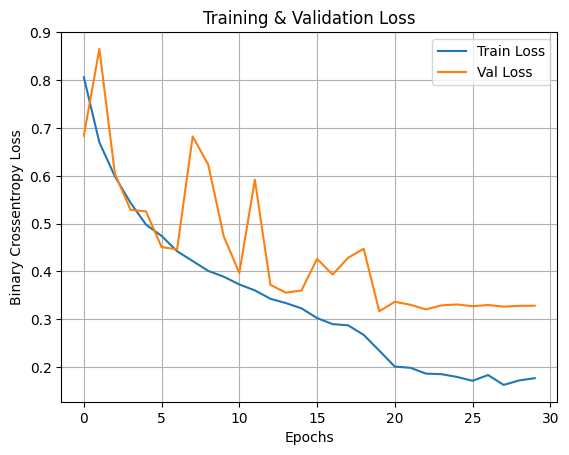

CNN_Model Test Accuracy: 86.50%


In [11]:
def build_cnn_model(input_shape=(32, 32, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()

cnn_history,cnn_test_results = train_and_evaluate_model(cnn_model, train_dataset_32, test_dataset_32 , val_dataset_32,
                             epochs=40, model_name="CNN_Model",
                            callbacks=callbacks)


In [12]:
cnn_model.save("F:\Desktop\project\models\cnn_cifar_model.keras")

In [13]:
cnn_result = report(cnn_model,"cnn_cifar_model",cnn_history,test_dataset_32)

cnn_cifar_model
True labels shape: (1000,)
Predicted labels shape: (1000,)

Confusion Matrix:
[[452  48]
 [ 87 413]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       500
           1       0.90      0.83      0.86       500

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

Results saved to: F:\Desktop\project\results_cnn_cifar_model.json


In [27]:
input_shape = (64,64,3)
cnn64_model = build_cnn_model(input_shape=input_shape)
cnn64_history,cnn64_test_results = train_and_evaluate_model(cnn64_model, train_dataset_64, test_dataset_64 , val_dataset_64,
                             epochs=40, model_name="CNN64_Model",
                            callbacks=callbacks)
cm_cnn64, cr_cnn64, cnn64_result = report(cnn64_model,cnn64_history,test_dataset_64)

Epoch 1/40


f:\Desktop\project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 458ms/step - accuracy: 0.5702 - loss: 0.7583 - val_accuracy: 0.5000 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 492ms/step - accuracy: 0.6086 - loss: 0.6730 - val_accuracy: 0.5650 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.6764 - loss: 0.5997 - val_accuracy: 0.7100 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 461ms/step - accuracy: 0.7092 - loss: 0.5621 - val_accuracy: 0.7510 - val_loss: 0.5206 - learning_rate: 0.0010
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 464ms/step - accuracy: 0.7319 - loss: 0.5280 - val_accuracy: 0.7420 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 478ms/step - accuracy: 0.7495 - loss: 0.5048 - val_accuracy: 0.7230 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 7/40
117/313 ━━━━━━━━━━━━━━━━━━━━ 1:17 395ms/step - accuracy: 0.7536 

KeyboardInterrupt: 

#vgg16 model

In [12]:
weights_path = r'F:\Desktop\project\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [13]:
def build_vgg16(input_shape=(32, 32, 3)):
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(weights=weights_path, include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    inputs = Input(shape=(32,32,3))
    x = RandomFlip("horizontal")(inputs)
    x = RandomRotation(0.1)(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

vgg16_model = build_vgg16()

In [16]:
vgg16_model.summary(expand_nested=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_conv1 (Conv2D)      │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_conv2 (Conv2D)      │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_conv1 (Conv2D)      │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_conv2 (Conv2D)      │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_pool (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv1 (Conv2D)      │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv2 (Conv2D)      │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv3 (Conv2D)      │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_pool (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv1 (Conv2D)      │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv2 (Conv2D)      │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv3 (Conv2D)      │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_pool (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv1 (Conv2D)      │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv2 (Conv2D)      │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv3 (Conv2D)      │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_pool (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - accuracy: 0.5831 - loss: 0.6794 - val_accuracy: 0.6910 - val_loss: 0.6035 - learning_rate: 1.0000e-04
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 186ms/step - accuracy: 0.6460 - loss: 0.6264 - val_accuracy: 0.7020 - val_loss: 0.5818 - learning_rate: 1.0000e-04
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 186ms/step - accuracy: 0.6763 - loss: 0.6050 - val_accuracy: 0.7130 - val_loss: 0.5723 - learning_rate: 1.0000e-04
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - accuracy: 0.6791 - loss: 0.5994 - val_accuracy: 0.7140 - val_loss: 0.5643 - learning_rate: 1.0000e-04
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 211ms/step - accuracy: 0.6787 - loss: 0.5926 - val_accuracy: 0.7120 - val_loss: 0.5611 - learning_rate: 1.0000e-04
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 221ms/step - accuracy: 0.6921 - loss: 0.5826 - val_accuracy: 0.7150 - val_loss: 0.5584 - learning_rate: 1.0000e-04
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 23

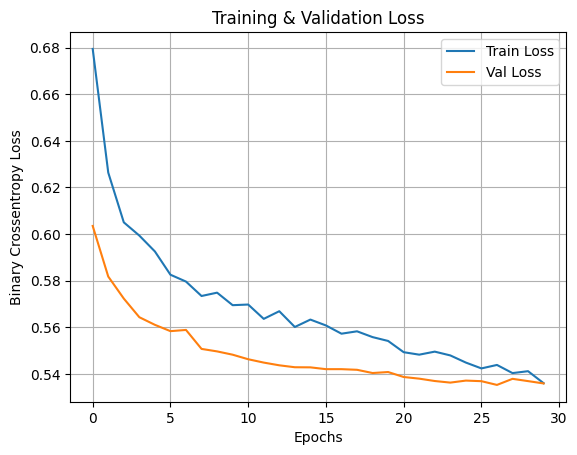

vgg16_Model Test Accuracy: 72.50%


In [37]:
vgg16_history,vgg16_test_results = train_and_evaluate_model(vgg16_model, train_dataset_32, test_dataset_32 , val_dataset_32,
                             epochs=30, model_name="vgg16_Model",
                            callbacks=callbacks)


In [41]:
vgg16_model.save(r"F:\Desktop\project\models\vgg_cifar_model.keras")

In [38]:
vgg_result = report(vgg16_model,"vgg_cifar_model",vgg16_history,test_dataset_32)

vgg_cifar_model
True labels shape: (1000,)
Predicted labels shape: (1000,)

Confusion Matrix:
[[369 131]
 [144 356]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       500
           1       0.73      0.71      0.72       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000

Results saved to: F:\Desktop\project\results_vgg_cifar_model.json
